# 1. Training from scratch: 
As we have only few training dataset(1000 images for each class), the accuracy we observed is very less(Training accuracy: 81.8% Testing accuracy: 79%) with 50 Epochs

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 19s 148ms/step - loss: 0.7179 - acc: 0.5190 - val_loss: 0.7549 - val_acc: 0.5000
Epoch 2/50
125/125 [==============================] - 17s 135ms/step - loss: 0.6777 - acc: 0.5865 - val_loss: 0.6167 - val_acc: 0.6587
Epoch 3/50
125/125 [==============================] - 16s 129ms/step - loss: 0.6503 - acc: 0.6375 - val_loss: 0.6213 - val_acc: 0.6550
Epoch 4/50
125/125 [==============================] - 16s 129ms/step - loss: 0.6314 - acc: 0.6580 - val_loss: 0.5815 - val_acc: 0.6875
Epoch 5/50
125/125 [==============================] - 16s 128ms/step - loss: 0.6032 - acc: 0.6690 - val_loss: 0.9528 - val_acc: 0.5300
Epoch 6/50
125/125 [==============================] - 16s 130ms/step - loss: 0.5849 - acc: 0.6980 - val_loss: 0.5747 - val_acc: 0.6975
Epoch 7/50
125/125 [==============================] - 17s 136ms/step - loss: 0.5717 - acc: 0.7015 - val_los

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

# 2. Using the bottleneck features of a pre-trained network
Here we are using VGG16 models conv layers without fully connected layers. We train our model only on newly adeded fully connected layer. It improves the accuracy drastically. Training accuracy: 99.65% Testing accuracy: 89.38% with 50 Epochs

In [7]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', "rb", buffering=0))
    train_labels = np.array(
        [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy', "rb", buffering=0))
    validation_labels = np.array(
        [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    model.summary()


save_bottlebeck_features()
train_top_model()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 2s 797us/step - loss: 0.7193 - acc: 0.7510 - val_loss: 0.2727 - val_acc: 0.8912
Epoch 2/50
2000/2000 [==============================] - 1s 440us/step - loss: 0.3724 - acc: 0.8555 - val_loss: 0.2480 - val_acc: 0.8900
Epoch 3/50
2000/2000 [==============================] - 1s 475us/step - loss: 0.3116 - acc: 0.8800 - val_loss: 0.2302 - val_acc: 0.9075
Epoch 4/50
2000/2000 [==============================] - 1s 475us/step - loss: 0.2807 - acc: 0.8920 - val_loss: 0.8308 - val_acc: 0.7300
Epoch 5/50
2000/2000 [==============================] - 1s 540us/step - loss: 0.2371 - acc: 0.9100 - val_loss: 0.3093 - val_acc: 0.9062
Epoch 6/50
2000/2000 [==============================] - 1s 469us/step - loss: 0.2236 - acc: 0.9155 - val_loss: 0.4095 - val_acc: 0.8712
Epoch 7/50
2000/2000 [==============================] 

# 3. Fine-tuning the top layers of a a pre-trained network
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

-instantiate the convolutional base of VGG16 and load its weights
-add our previously defined fully-connected model on top, and load its weights
-freeze the layers of the VGG16 model up to the last convolutional block

Training accuracy: 93.80% Testing accuracy: 89.38% with 5 Epochs

In [9]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Input, Model
from keras.layers import Dropout, Flatten, Dense
from keras import backend as K

# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 5
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# build the VGG16 network
#input_tensor1 = Input(shape=(img_width,img_height,3))
model = applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
#model.add(top_model)
model = Model(inputs= model.input, outputs= top_model(model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

Model loaded.
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


C:\Users\Swapnanil\Anaconda3_New\lib\site-packages\ipykernel_launcher.py:85: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Swapnanil\Anaconda3_New\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=5, validation_data=<keras.pre..., steps_per_epoch=125, validation_steps=800)`


Epoch 1/5
125/125 [==============================] - 87s 700ms/step - loss: 0.5378 - acc: 0.9355 - val_loss: 0.9566 - val_acc: 0.8938
Epoch 2/5
125/125 [==============================] - 89s 712ms/step - loss: 0.5641 - acc: 0.9330 - val_loss: 0.9566 - val_acc: 0.8938
Epoch 3/5
125/125 [==============================] - 88s 706ms/step - loss: 0.5025 - acc: 0.9360 - val_loss: 0.9566 - val_acc: 0.8938
Epoch 4/5
125/125 [==============================] - 88s 701ms/step - loss: 0.5565 - acc: 0.9310 - val_loss: 0.9566 - val_acc: 0.8938
Epoch 5/5
125/125 [==============================] - 88s 707ms/step - loss: 0.4724 - acc: 0.9380 - val_loss: 0.9566 - val_acc: 0.8938


In [28]:
model.save("final_fine_tune_weight.h5")

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [11]:
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 0
Non-trainable params: 2,097,665
_________________________________________________________________


In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, predict_y):
    C = confusion_matrix(y_test, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    
    B =(C/C.sum(axis=0))
   
    labels = [0,1]   #[0,1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Predicting a new image class

In [43]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('final_fine_tune_weight.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

def print_class(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(150,150))
    img = np.reshape(img,[1,150,150,3])
    classes = model.predict(img)
    if classes[0][0]==0.0:
        print("It is a Cat")
    elif classes[0][0]==1.0:
        print("It is a Dog")

def return_class(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(150,150))
    img = np.reshape(img,[1,150,150,3])
    classes = model.predict(img)
    return int(classes[0][0])
    

print_class("test.jpg")
print(return_class("test1.jpg"))

C:\Users\Swapnanil\Anaconda3_New\lib\site-packages\keras\models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


It is a Cat
1


# Confusion matrix for the fine tune model

-------------------------------------------------- Confusion matrix --------------------------------------------------


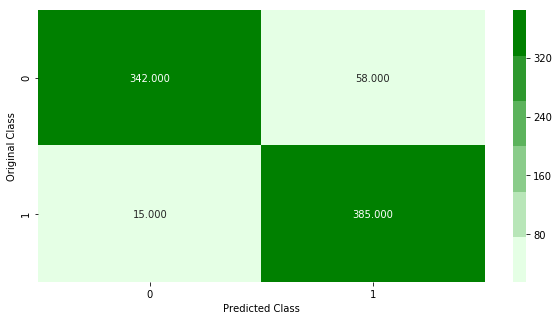

-------------------------------------------------- Precision matrix --------------------------------------------------


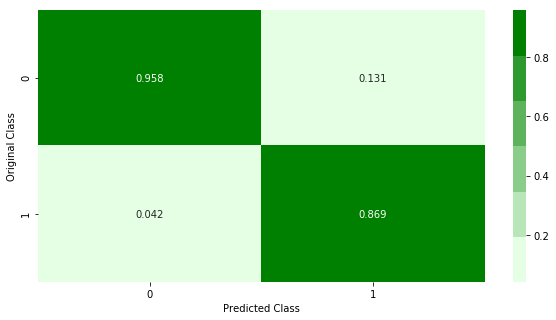

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


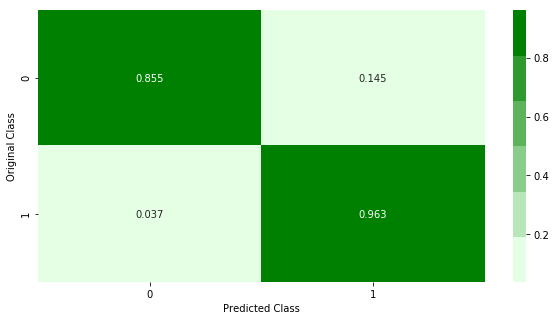

Sum of rows in precision matrix [1. 1.]


In [70]:
nb_validation_samples = 800
validation_actual = np.array(
        [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))
validation_predicted = []
j=k=0
for i in range(int(nb_validation_samples / 2)):
    j=1000+i
    validation_predicted.append(return_class("data/validation/cats/cat.%s.jpg" % j))

for i in range(int(nb_validation_samples / 2)):
    k=1000+i
    validation_predicted.append(return_class("data/validation/dogs/dog.%s.jpg" % k))
validation_predicted = np.array(validation_predicted)


plot_confusion_matrix(validation_actual, validation_predicted)